In [270]:
import pandas as pd
import json
import re

def clean_output(output):
    cleaned_output = output
    # Extract XML code from the output
    xml_code = re.search(r'```json(.*?)```', output, re.DOTALL)
    cleaned_output = ''
    if xml_code:
        cleaned_output = xml_code.group(1).strip()
    
    # Parse the JSON
    try:
        # cleaned_output = json.loads(cleaned_output)
        cleaned_output = eval(cleaned_output)
    except:
        return {}
    
    return cleaned_output

def get_metrics(predictions, model_name, seen_fes=None, compute_unseen_metrics=False):

    frame_tp = {frame: 0 for frame in predictions['frame'].unique()}
    frame_fp = {frame: 0 for frame in predictions['frame'].unique()}
    frame_fn = {frame: 0 for frame in predictions['frame'].unique()}
    
    skipped = 0

    for pred, fes, frame in predictions[['prediction', 'output', 'frame']].values:

        # Get each predicted FE span from the prediction
        pred_tags = pred
        real_tags = fes

        # Check each predicted FE span
        for tag, content in pred_tags.items():
            if seen_fes and compute_unseen_metrics and (frame, tag.capitalize()) in seen_fes:
                skipped += 1
                continue
            
            if tag.capitalize() in real_tags:
                if content == real_tags[tag.capitalize()]:
                    frame_tp[frame] += 1
                else:
                    frame_fp[frame] += 1
            else:
                frame_fp[frame] += 1
        
        # Check each real FE span
        for tag, content in real_tags.items():
            if seen_fes and compute_unseen_metrics and (frame, tag.capitalize()) in seen_fes:
                skipped += 1
                continue
            
            if tag not in pred_tags:
                frame_fn[frame] += 1
            elif content != pred_tags[tag]:
                frame_fn[frame] += 1
    
    print(f'Skipped {skipped} of {len(predictions)} seen FEs')
    return [{'model': model_name, 'frame': fr, 'tp': frame_tp[fr], 'fp': frame_fp[fr], 'fn': frame_fn[fr]} for fr in frame_tp]

train_data = pd.read_json('fn1.7-train-prompts.jsonl', lines=True)
train_data['frame'] = train_data.messages.apply(lambda x: x[1]['content'].split('\n')[1].split(': ')[1])
train_data['output'] = train_data.messages.apply(lambda x: clean_output(x[-1]['content']))
train_data['all_fes'] = train_data.messages.apply(lambda x: set([a.split(' ')[0] for a in x[1]['content'].split('\n')[5:-4]]))

test_data = pd.read_json('../../data/raw/os_test.jsonl', lines=True)
test_data = test_data[test_data.fe.apply(lambda x: len(x) > 0)].reset_index()

model_names = {
    './phi-4/fn1.7-test-01-predictions.jsonl': '1%',
    './phi-4/fn1.7-test-05-predictions.jsonl': '5%',
    './phi-4/fn1.7-test-10-predictions.jsonl': '10%',
    './phi-4/fn1.7-test-25-predictions.jsonl': '25%',
    './phi-4/fn1.7-test-50-predictions.jsonl': '50%',
    './phi-4/fn1.7-test-75-predictions.jsonl': '75%',
    './phi-4/fn1.7-test-predictions.jsonl': '100%',
}

# predictions = pd.read_json('fn1.7-test-predictions.jsonl', lines=True)
# predictions['output'] = predictions.apply(lambda x: clean_output(x['messages'][-1]['content']), axis=1)
# predictions['prediction'] = predictions.apply(lambda x: clean_output(x['predictions']), axis=1)

# predictions['frame'] = test_data['frame']

predictions = pd.DataFrame({'output': [], 'prediction': [], 'frame': [], 'model':[]})
model_metrics = []

for pred_file, name in model_names.items():
    pred = pd.read_json(pred_file, lines=pred_file.endswith('jsonl'))
    pred['output'] = pred.apply(lambda x: clean_output(x['messages'][-1]['content']), axis=1)
    pred['prediction'] = pred.apply(lambda x: clean_output(x['predictions']), axis=1)
    pred['frame'] = test_data['frame'].copy()
    pred['model'] = pred_file

    
    # seen_fes = train_data.sample(frac=int(name[:-1])/100, random_state=0).explode('output').rename(columns={'output': 'fe'})[['frame', 'fe']].drop_duplicates().apply(lambda x: (x['frame'], x['fe']), axis=1)
    # seen_fes = set(seen_fes)
    seen_frames_fes = train_data.sample(frac=int(name[:-1])/100, random_state=0).explode('all_fes')[['frame', 'all_fes']].drop_duplicates().apply(lambda x: (x['frame'], x['all_fes']), axis=1)
    seen_fes = set(seen_frames_fes)

    metrics_unseen = get_metrics(pred, pred_file, seen_fes=seen_fes, compute_unseen_metrics=True)
    metrics_unseen = pd.DataFrame(metrics_unseen)
    metrics_unseen['seen'] = True
    metrics_unseen = metrics_unseen.to_dict(orient='records')

    metrics_seen = get_metrics(pred, pred_file, seen_fes=None, compute_unseen_metrics=False)
    metrics_seen = pd.DataFrame(metrics_seen)
    metrics_seen['seen'] = False
    metrics_seen = metrics_seen.to_dict(orient='records')
    
    # model_metrics.extend(metrics)
    model_metrics.extend(metrics_unseen)
    model_metrics.extend(metrics_seen)


model_metrics = pd.DataFrame(model_metrics)
model_metrics['precision'] = model_metrics['tp'] / (model_metrics['tp'] + model_metrics['fp'])
model_metrics['recall'] = model_metrics['tp'] / (model_metrics['tp'] + model_metrics['fn'])
model_metrics['f1'] = 2 * (model_metrics['precision'] * model_metrics['recall']) / (model_metrics['precision'] + model_metrics['recall'])
model_metrics['accuracy'] = model_metrics['tp'] / (model_metrics['tp'] + model_metrics['fp'] + model_metrics['fn'])

model_metrics['model_name'] = model_metrics['model'].apply(lambda x: model_names[x])

Skipped 10474 of 6223 seen FEs
Skipped 0 of 6223 seen FEs
Skipped 17287 of 6223 seen FEs
Skipped 0 of 6223 seen FEs
Skipped 18316 of 6223 seen FEs
Skipped 0 of 6223 seen FEs
Skipped 20286 of 6223 seen FEs
Skipped 0 of 6223 seen FEs
Skipped 20922 of 6223 seen FEs
Skipped 0 of 6223 seen FEs
Skipped 21514 of 6223 seen FEs
Skipped 0 of 6223 seen FEs
Skipped 21393 of 6223 seen FEs
Skipped 0 of 6223 seen FEs


In [271]:
# Compute overall metrics per model
# Keys: model	frame	tp	fp	fn	precision	recall	f1	accuracy	model_name
# Precision
precisions = model_metrics.groupby('model_name').tp.sum() / (model_metrics.groupby('model_name').tp.sum() + model_metrics.groupby('model_name').fp.sum())
# Recall
recalls = model_metrics.groupby('model_name').tp.sum() / (model_metrics.groupby('model_name').tp.sum() + model_metrics.groupby('model_name').fn.sum())
# F1
f1s = 2 * (precisions * recalls) / (precisions + recalls)
# Accuracy
accuracies = model_metrics.groupby('model_name').tp.sum() / (model_metrics.groupby('model_name').tp.sum() + model_metrics.groupby('model_name').fp.sum() + model_metrics.groupby('model_name').fn.sum())

In [272]:
precisions.sort_values(), recalls.sort_values(), f1s.sort_values(), accuracies.sort_values()
# f1s.sort_values(), accuracies.sort_values(),

# Unseen FEs
# (model_name
#  1%      0.523628
#  5%      0.628819
#  10%     0.705602
#  25%     0.750632
#  50%     0.766396
#  75%     0.771661
#  100%    0.783631
#  dtype: float64,
#  model_name
#  1%      0.442151
#  5%      0.556471
#  10%     0.614996
#  25%     0.698646
#  50%     0.733587
#  75%     0.760283
#  100%    0.763752
#  dtype: float64,
#  model_name
#  1%      0.479453
#  5%      0.590437
#  10%     0.657191
#  25%     0.723706
#  50%     0.749633
#  75%     0.765930
#  100%    0.773564
#  dtype: float64,
#  model_name
#  1%      0.315316
#  5%      0.418880
#  10%     0.489415
#  25%     0.567037
#  50%     0.599530
#  75%     0.620653
#  100%    0.630742
#  dtype: float64)

# Unseen Frames
# (model_name
#  1%      0.533677
#  5%      0.643791
#  10%     0.720066
#  25%     0.761813
#  50%     0.775080
#  75%     0.780850
#  100%    0.792038
#  dtype: float64,
#  model_name
#  1%      0.462224
#  5%      0.585164
#  10%     0.646222
#  25%     0.722998
#  50%     0.751666
#  75%     0.774948
#  100%    0.776266
#  dtype: float64,
#  model_name
#  1%      0.495387
#  5%      0.613079
#  10%     0.681148
#  25%     0.741898
#  50%     0.763194
#  75%     0.777888
#  100%    0.784073
#  dtype: float64,
#  model_name
#  1%      0.329246
#  5%      0.442043
#  10%     0.516471
#  25%     0.589696
#  50%     0.617068
#  75%     0.636511
#  100%    0.644835
#  dtype: float64)

(model_name
 1%      0.533677
 5%      0.643791
 10%     0.720066
 25%     0.761813
 50%     0.775080
 75%     0.780850
 100%    0.792038
 dtype: float64,
 model_name
 1%      0.462224
 5%      0.585164
 10%     0.646222
 25%     0.722998
 50%     0.751666
 75%     0.774948
 100%    0.776266
 dtype: float64,
 model_name
 1%      0.495387
 5%      0.613079
 10%     0.681148
 25%     0.741898
 50%     0.763194
 75%     0.777888
 100%    0.784073
 dtype: float64,
 model_name
 1%      0.329246
 5%      0.442043
 10%     0.516471
 25%     0.589696
 50%     0.617068
 75%     0.636511
 100%    0.644835
 dtype: float64)

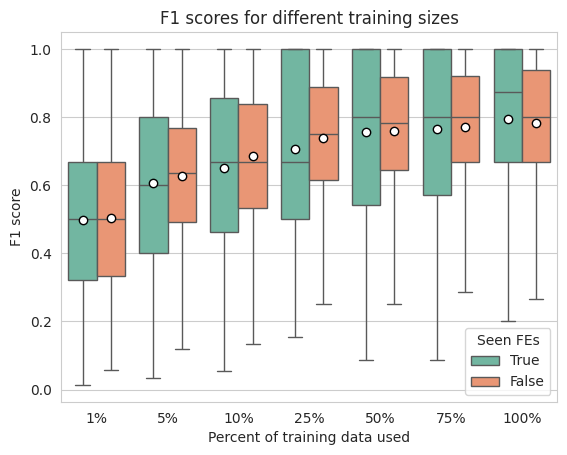

In [267]:
# Plot histogram of the F1 scores
import seaborn as sns
import matplotlib.pyplot as plt

# Set style and palette
pal = sns.color_palette("Set2", len(model_metrics['seen'].unique()))

# Boxplot with circles for means
g = sns.boxplot(hue='seen', x='model_name', y='f1', data=model_metrics, 
                palette=pal, linewidth=1, fliersize=0, 
                order=model_metrics.groupby('model_name').f1.mean().sort_values().index,
                hue_order=[True, False],
                showfliers=False, showmeans=True, meanprops=dict(marker='o', markerfacecolor='white', markeredgecolor='black'))

g.set_title('F1 scores for different training sizes')
g.set_xlabel('Percent of training data used')
g.set_ylabel('F1 score')

g.legend(title='Seen FEs')

# plt.dpi = 1200

plt.show()
# plt.tight_layout()

# plt.savefig('subsets_f1_unseen.png', dpi=1200)

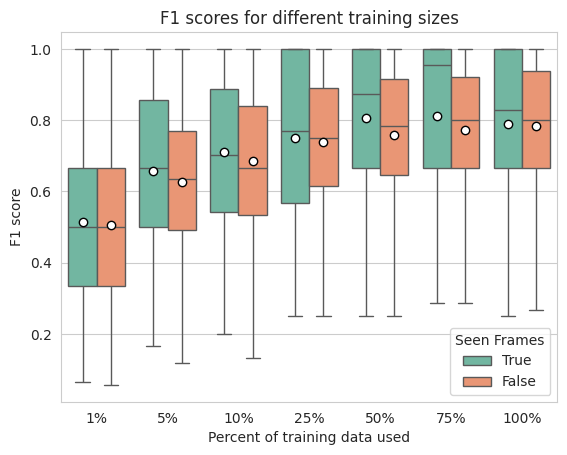

In [264]:
# Plot histogram of the F1 scores
import seaborn as sns
import matplotlib.pyplot as plt

# Set style and palette
pal = sns.color_palette("Set2", len(model_metrics['seen'].unique()))

# Boxplot with circles for means
g = sns.boxplot(hue='seen', x='model_name', y='f1', data=model_metrics, 
                palette=pal, linewidth=1, fliersize=0, 
                order=model_metrics.groupby('model_name').f1.mean().sort_values().index,
                hue_order=[True, False],
                showfliers=False, showmeans=True, meanprops=dict(marker='o', markerfacecolor='white', markeredgecolor='black'))

g.set_title('F1 scores for different training sizes')
g.set_xlabel('Percent of training data used')
g.set_ylabel('F1 score')

g.legend(title='Seen Frames')

# plt.dpi = 1200

plt.show()
# plt.tight_layout()

# plt.savefig('subsets_f1_unseen.png', dpi=1200)

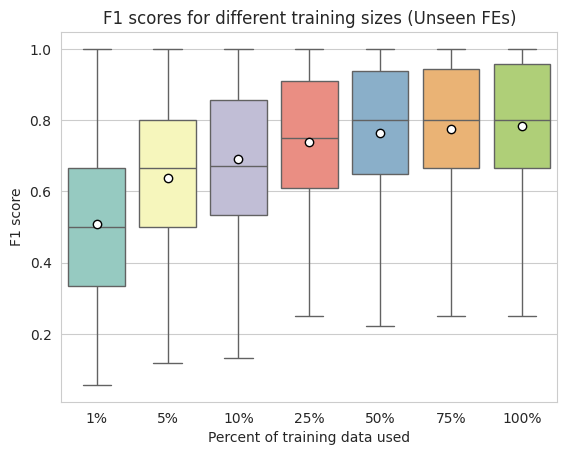

In [262]:
# Plot histogram of the F1 scores
import seaborn as sns
import matplotlib.pyplot as plt

# Set style and palette
pal = sns.color_palette("Set3", len(model_metrics['model_name'].unique()))

# Boxplot with circles for means
g = sns.boxplot(hue='model_name', x='model_name', y='f1', data=model_metrics, 
                palette=pal, linewidth=1, fliersize=0, 
                order=model_metrics.groupby('model_name').f1.mean().sort_values().index,
                showfliers=False, showmeans=True, meanprops=dict(marker='o', markerfacecolor='white', markeredgecolor='black'))

g.set_title('F1 scores for different training sizes (Unseen FEs)')
g.set_xlabel('Percent of training data used')
g.set_ylabel('F1 score')

# plt.dpi = 1200

plt.show()
# plt.tight_layout()

# plt.savefig('subsets_f1_unseen.png', dpi=1200)